# Create appealing visuals
# Learn from data to see what to include in model
# create new variables that might work better

# OUTPUT:
## A file full of photos - graphs charts, ect.
## The final df to be used in the modeling process saved as a mySQL table, then to excel.
    
    

In [111]:
import mysql.connector
import getpass
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd


In [112]:
cnx = mysql.connector.connect(host="localhost",user="root",password=getpass.getpass('Enter password: '),database="senate_0424")

Enter password: ········


In [113]:
def sql(query):
    cur = cnx.cursor(buffered=True)
    cur.execute(query)
    try:
        for x in cur:
            print(x)
    except TypeError as e:
        print("SUCCESS: but bro there is nothing to print", e)

In [114]:
def todf(query):
    df = pd.read_sql(query, cnx)
    return df

In [115]:
def u(table_name, column_name):
    query = f'SELECT DISTINCT {column_name} FROM {table_name};'
    return query

In [116]:
sql('SHOW TABLES')

('demographics',)
('elections',)
('finances',)
('results',)


In [117]:
results_df = todf("SELECT * FROM results")
results_df.head(5)

,year,state,fec_id,incumbent,first_name,last_name,party,votes,vote_share,total_votes,is_male,white,black,age
0,2016,AK,S0AK00121,0,Joe,Miller,L,90825,0.292,311441,1,1,0,48
1,2016,AR,S0AR00150,1,John,Boozman,R,661984,0.598,1107522,1,1,0,65
2,2016,CO,S0CO00211,1,Michael,Bennet,D,1370710,0.500,2743029,1,1,0,51
3,2016,CT,S0CT00177,1,Richard,Blumenthal,D,920766,0.577,1596276,1,1,0,70
4,2016,CT,S0CT00250,0,Jeffery,Russell,O,16713,0.010,1596276,1,1,0,56


In [118]:
finances_df = todf("SELECT * FROM finances")
finances_df.head(5)

,year,committee_id,fec_id,committee_name,total_raised,total_spent,cash_start,cash_end
0,2016,C00148999,S6IL00151,FRIENDS OF DICK DURBIN,1151490.0,1073760.0,741450.0,819176.0
1,2016,C00193342,S2KY00012,MCCONNELL SENATE COMMITTEE,2154060.0,1476860.0,248241.0,925444.0
2,2016,C00193623,S6AL00013,SHELBY FOR U S SENATE,3467640.0,11531400.0,18055400.0,9991640.0
3,2016,C00196774,S4MA00028,MARKEY COMMITTEE; THE,601552.0,803795.0,2227330.0,2025090.0
4,2016,C00230482,S0IA00028,GRASSLEY COMMITTEE INC,8954940.0,9787430.0,1838650.0,1006160.0


In [119]:
elections_df = todf("SELECT * FROM elections")
elections_df.head(5)

,year,state,vote_turnout,total_raised,total_spent,cash_start,cash_end
0,2016,AK,0.4802,6137850.0,7812960.0,1183380.0,353721.0
1,2016,AL,0.4296,3500910.0,11563800.0,18055400.0,9992080.0
2,2016,AR,0.4007,8123460.0,7903670.0,485392.0,742600.0
3,2016,CA,0.2839,592780.0,466186.0,2297760.0,2424360.0
4,2016,CO,0.5930,20781800.0,20219600.0,1511460.0,2073650.0


In [120]:
demographics_df = todf("SELECT * FROM demographics")
demographics_df['year'] += 1
demographics_df.head(5)

,year,state,total_pop,median_age,white_pop,black_pop,male,female,high_school,bach,born_in_state,employment,inflation
0,2015,AK,736732,33,455009,23608,385582,351150,33253,85634,123013,6,236
1,2016,AK,738432,33,452472,24739,388695,349737,34616,87869,128626,6,237
2,2017,AK,741894,33,452757,21768,390573,351321,32977,90861,128699,6,240
3,2018,AK,739795,34,448081,21192,385776,354019,40036,86444,139475,6,245
4,2019,AK,737438,34,443304,24011,382952,354486,32444,89635,133565,6,251


# Begin feature transformations
## Demogrpahics data is delayed purposefully. Here the change in unemployment rate bewteen last year and two years ago is used.

In [121]:
df = todf('''

SELECT 
    year, 
    fec_id, 
    COUNT(DISTINCT committee_id) AS number_of_comm,
    SUM(total_raised) AS total_raised_candidate,
    SUM(total_spent) AS total_spent_candidate,
    SUM(cash_start) AS cash_start_candidate,
    SUM(cash_end) AS cash_end_candidate
FROM finances
GROUP BY year, fec_id;

''')
merged_df = results_df.merge(df, how='left', on=['year', 'fec_id'])

merged_df.isna().sum()

# Drop the specified columns
merged_df = merged_df.drop(columns=['first_name', 'last_name'])

# Drop rows with NA values
merged_df2 = merged_df.dropna()
merged_df2.head()

,year,state,fec_id,incumbent,party,votes,vote_share,total_votes,is_male,white,black,age,number_of_comm,total_raised_candidate,total_spent_candidate,cash_start_candidate,cash_end_candidate
0,2016,AK,S0AK00121,0,L,90825,0.292,311441,1,1,0,48,1.0,387524.0,4.111840e+05,9.972500e+04,7.606300e+04
1,2016,AR,S0AR00150,1,R,661984,0.598,1107522,1,1,0,65,1.0,4178410.0,3.988330e+06,2.686020e+05,4.586820e+05
2,2016,CO,S0CO00211,1,D,1370710,0.500,2743029,1,1,0,51,4.0,15692371.0,1.520520e+07,1.234402e+06,1.721575e+06
3,2016,CT,S0CT00177,1,D,920766,0.577,1596276,1,1,0,70,3.0,7583918.0,5.291608e+06,6.611110e+05,2.953419e+06
5,2016,FL,S0FL00338,1,R,4835191,0.520,9301820,1,1,0,44,2.0,21344259.0,2.116744e+07,4.672897e+04,2.235509e+05


In [122]:
merged_df3 = merged_df2.merge(elections_df, how='left', on=['year', 'state'])
# Calculate ratios
#merged_df3['total_raised_candidate_ratio'] = merged_df3['total_raised_candidate'] / merged_df3['total_raised']
#merged_df3['total_spent_candidate_ratio'] = merged_df3['total_spent_candidate'] / merged_df3['total_spent']
#merged_df3['cash_start_candidate_ratio'] = merged_df3['cash_start_candidate'] / merged_df3['cash_start']
#merged_df3['cash_end_candidate_ratio'] = merged_df3['cash_end_candidate'] / merged_df3['cash_end']

merged_df4 = merged_df3.merge(demographics_df, how='left', on=['year', 'state'])

In [123]:
# Select the specified columns
merged_df5 = merged_df4.loc[:, ['year', 'state', 'fec_id', 'incumbent', 'party', 'number_of_comm',
                               'high_school', 'bach', 'age', 'median_age', 'total_pop','vote_share', 'total_raised_candidate','total_spent_candidate']]

In [124]:
merged_df5['total_raised_by_population'] = merged_df5['total_raised_candidate'] / merged_df5['total_pop']
merged_df5['total_spent_by_population'] = merged_df5['total_spent_candidate'] / merged_df5['total_pop']
merged_df5 = merged_df5.drop(columns=['total_raised_candidate','total_spent_candidate','total_spent_candidate'])

In [125]:
# Calculate the ratio of 'bach' to 'high_school' and create a new column
merged_df5['bach_high_school_ratio'] = merged_df5['bach'] / merged_df5['high_school']

# Drop the 'bach' and 'high_school' columns
merged_df5 = merged_df5.drop(columns=['bach', 'high_school'])

In [126]:
merged_df5['state_size'] = pd.qcut(merged_df5['total_pop'], q=6, labels=False)
merged_df5['candidate_age'] = pd.qcut(merged_df5['age'], q=4, labels=False)
#merged_df5['median_age_cat'] = pd.qcut(merged_df5['median_age'], q=4, labels=False)


In [127]:
# Drop the original columns
merged_df5 = merged_df5.drop(columns=['age', 'median_age'])
merged_df5 = merged_df5[merged_df5['total_spent_by_population'] <= 100]
# Display the updated DataFrame
merged_df5.head()


,year,state,fec_id,incumbent,party,number_of_comm,total_pop,vote_share,total_raised_by_population,total_spent_by_population,bach_high_school_ratio,state_size,candidate_age
0,2016,AK,S0AK00121,0,L,1.0,738432,0.292,0.524793,0.556834,2.538393,0,0
1,2016,AR,S0AR00150,1,R,1.0,2978204,0.598,1.402997,1.339173,0.961747,2,2
2,2016,CO,S0CO00211,1,D,4.0,5456574,0.500,2.875865,2.786583,2.806928,3,1
3,2016,CT,S0CT00177,1,D,3.0,3590886,0.577,2.111991,1.473622,2.212149,2,3
4,2016,FL,S0FL00338,1,R,2.0,20271272,0.520,1.052931,1.044209,1.471066,5,0


In [128]:
data = []

# Iterate over each unique pair of 'year' and 'state' between 2017 and 2020
for year in range(2016, 2021):
    for state in demographics_df['state'].unique():
        # Filter the DataFrame for the current year and state
        df_subset = demographics_df[(demographics_df['year'] <= year) & (demographics_df['state'] == state)]
        
        # Calculate the change in employment and inflation data
        delayed_employment = df_subset.loc[df_subset['year'] == year, 'employment'].values - df_subset.loc[df_subset['year'] == year - 1, 'employment'].values
        delayed_inflation = df_subset.loc[df_subset['year'] == year, 'inflation'].values - df_subset.loc[df_subset['year'] == year - 1, 'inflation'].values
        

        d = int(delayed_employment) + int(delayed_inflation)
        # Append the data to the list
        data.append([year, state, d])

# Create a DataFrame from the list
econ_df = pd.DataFrame(data, columns=['year', 'state','delayed_econ'])

merged_df5 = merged_df5.merge(econ_df, how='left', on=['year', 'state'])

merged_df5

# Remove 'state' and 'year' columns
draft1 = merged_df5.drop(columns=['state', 'year', 'fec_id', 'total_pop'])


draft1.to_excel('draft1.xlsx', index=False)

In [129]:
# Get a list of column names
columns = list(draft1.columns)

# Remove the 'vote_share' column from the list
columns.remove('vote_share')

# Append the 'vote_share' column to the end of the list
columns.append('vote_share')

# Reorder the DataFrame columns
draft1 = draft1[columns]

draft1.head(10)


,incumbent,party,number_of_comm,total_raised_by_population,total_spent_by_population,bach_high_school_ratio,state_size,candidate_age,delayed_econ,vote_share
0,0,L,1.0,0.524793,0.556834,2.538393,0,0,1,0.292
1,1,R,1.0,1.402997,1.339173,0.961747,2,2,0,0.598
2,1,D,4.0,2.875865,2.786583,2.806928,3,1,0,0.500
3,1,D,3.0,2.111991,1.473622,2.212149,2,3,0,0.577
4,1,R,2.0,1.052931,1.044209,1.471066,5,0,0,0.520
5,0,R,1.0,0.045635,0.034118,2.278271,1,3,0,0.222
6,1,R,3.0,3.167125,3.433615,2.196342,2,3,0,0.601
7,1,O,1.0,1.543024,1.607629,2.092444,1,2,1,0.622
8,0,O,1.0,0.012451,0.013149,2.092444,1,2,1,0.322
9,1,R,2.0,1.514791,2.119637,0.916437,2,1,0,0.573


# Exploratory visuals
### Master List


In [130]:
plot_list = []
plot_list_names = []

In [131]:
#maroon = '#800000'
#orange = '#FFA500'
#palette = "ch:s=-.2,r=.6"

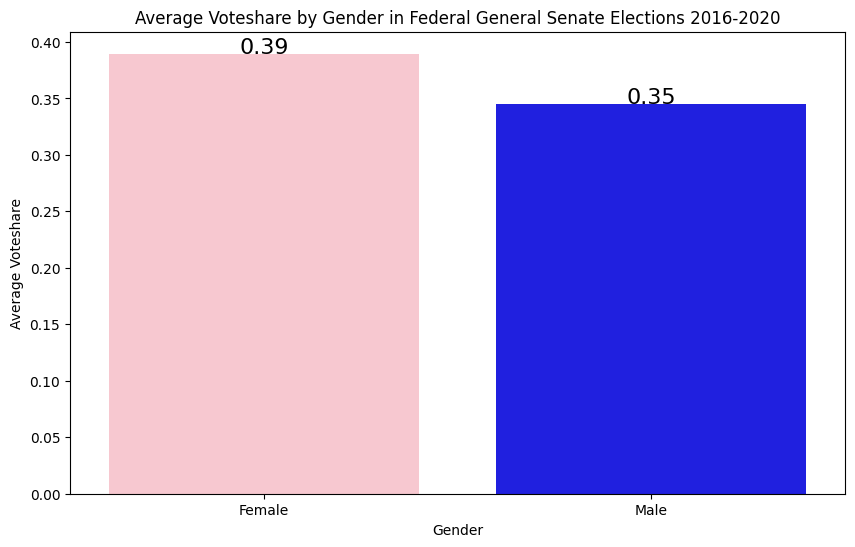

In [132]:
# Group by gender and calculate the mean of vote_share
average_voteshare_gender = results_df.groupby('is_male')['vote_share'].mean().reset_index()

# Plot the bar chart with specified colors
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='is_male', y='vote_share', data=average_voteshare_gender, palette=['pink', 'blue'])
title = 'Average Voteshare by Gender in Federal General Senate Elections 2016-2020'
plt.title(f'{title}')
plt.xlabel('Gender')
plt.ylabel('Average Voteshare')

# Add actual average voteshare values to the graph
for index, row in average_voteshare_gender.iterrows():
    ax.text(index, row['vote_share'], '{:.2f}'.format(row['vote_share']), color='black', ha="center", fontsize=16)
ax.set_xticklabels(['Female', 'Male'])  # Change the tick labels to 'Female' and 'Male'
plt.savefig('latest_gender.png')
plot_list.append(plt.gcf())
plot_list_names.append(title)
plt.show()


## results
#### Incumbency

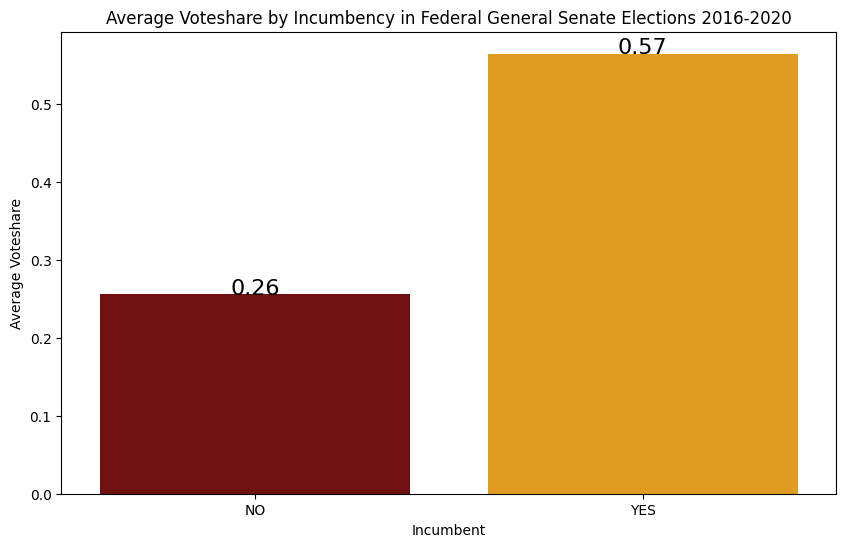

In [133]:
average_voteshare = results_df.groupby('incumbent')['vote_share'].mean().reset_index()

# Plot the bar chart with specified colors
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='incumbent', y='vote_share', data=average_voteshare, palette=['maroon', 'orange'])

title = 'Average Voteshare by Incumbency in Federal General Senate Elections 2016-2020'
plt.title(f'{title}')


plt.xlabel('Incumbent')
plt.ylabel('Average Voteshare')

# Add actual average voteshare values to the graph
for index, row in average_voteshare.iterrows():
    ax.text(index, row['vote_share'], '{:.2f}'.format(row['vote_share']), color='black', ha="center", fontsize=16)
ax.set_xticklabels(['NO', 'YES'])
plt.savefig('latest.png')
plot_list.append(plt.gcf())
plot_list_names.append(title)
plt.show()




#### candidates by age and gender

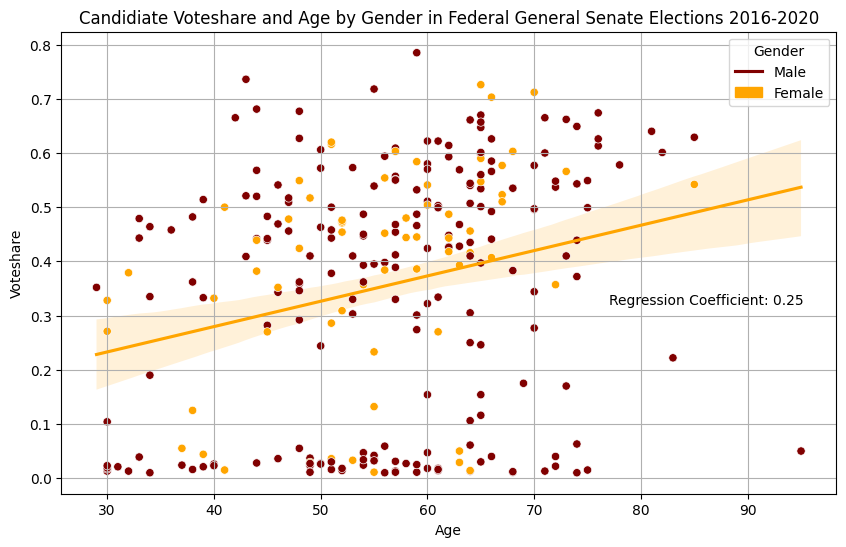

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.regplot(x='age', y='vote_share', data=results_df, scatter=False, line_kws={'color': 'orange'})
sns.scatterplot(x='age', y='vote_share', hue='is_male', data=results_df, palette=['maroon', 'orange'])


title = 'Candidiate Voteshare and Age by Gender in Federal General Senate Elections 2016-2020'
plt.title(f'{title}')

plt.xlabel('Age')
plt.ylabel('Voteshare')

# Calculate regression coefficient
reg_coef = results_df[['age', 'vote_share']].corr().iloc[0, 1]

# Add regression coefficient to the plot
plt.text(77, .32, f'Regression Coefficient: {reg_coef:.2f}',color='black')

plt.grid(True)  # Add gridlines for better readability
legend = plt.legend(title='Gender', labels=['Male', 'Female'])
legend.legendHandles[0].set_color('maroon')
legend.legendHandles[1].set_color('orange')

plt.savefig('latest.png')
plot_list.append(plt.gcf())
plot_list_names.append(title)
plt.show()



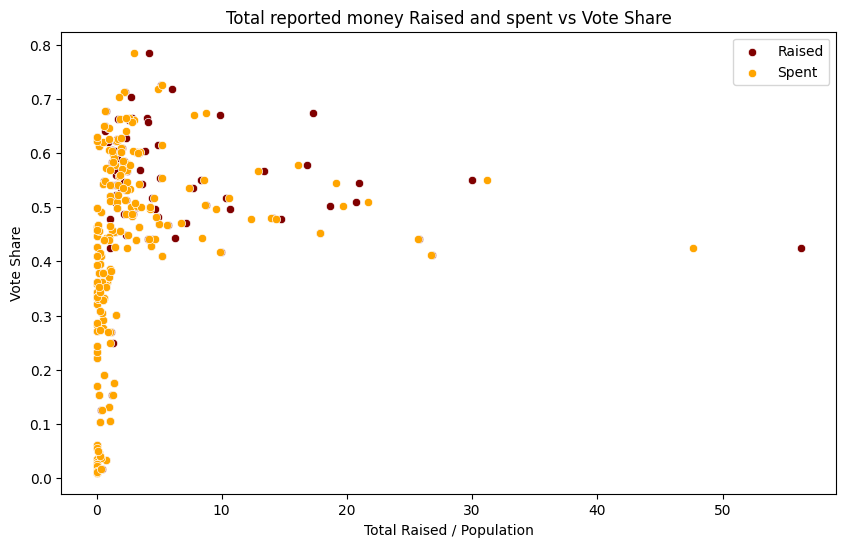

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the scatter plot for 'total_raised_by_population'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df5, x='total_raised_by_population', y='vote_share', color='maroon', label='Raised')

# Overlay the scatter plot for 'total_spent_by_population'
sns.scatterplot(data=merged_df5, x='total_spent_by_population', y='vote_share', color='orange', label='Spent')

# Add labels and title
plt.xlabel('Total Raised / Population')
plt.ylabel('Vote Share')
title = 'Total reported money Raised and spent vs Vote Share'
plt.title(f'{title}')


# Add legend
plt.legend()

# Save the plot
plt.savefig('latest_combined.png')

plt.savefig('latest.png')
plot_list.append(plt.gcf())
plot_list_names.append(title)
plt.show()



#### donation per person by state

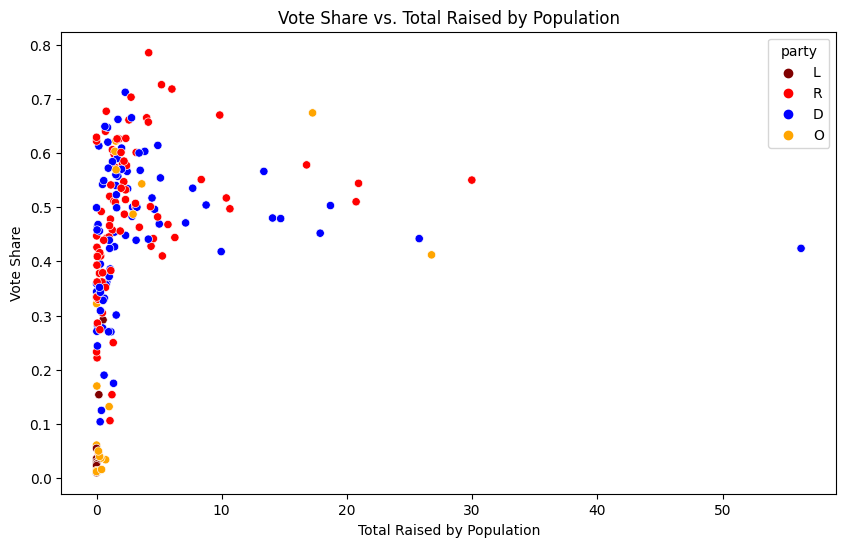

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df5, x='total_raised_by_population', y='vote_share', hue='party', palette=['maroon', 'red', 'blue', 'orange'])

# Add labels and title
plt.xlabel('Total Raised by Population')
plt.ylabel('Vote Share')


title = 'Vote Share vs. Total Raised by Population'
plt.title(f'{title}')

#plt.legend(title='Total Spent by Population', loc='upper right')

plt.savefig('latest.png')
plot_list.append(plt.gcf())
plot_list_names.append(title)
plt.show()


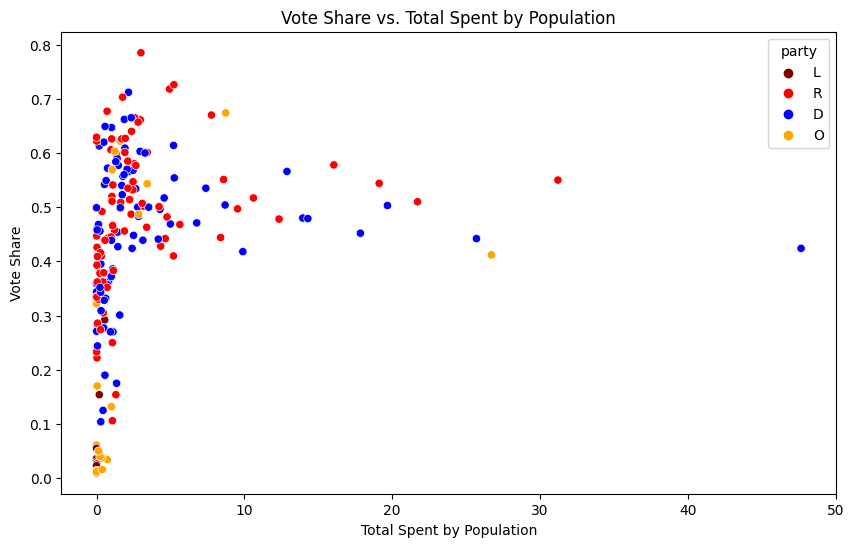

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df5, x='total_spent_by_population', y='vote_share', hue='party', palette=['maroon', 'red', 'blue', 'orange'])

# Add labels and title
plt.xlabel('Total Spent by Population')
plt.ylabel('Vote Share')


title = 'Vote Share vs. Total Spent by Population'
plt.title(f'{title}')

#plt.legend(title='Total Spent by Population', loc='upper right')

plt.savefig('latest.png')
plot_list.append(plt.gcf())
plot_list_names.append(title)
plt.show()


#### state map of the closeness of races by state

In [138]:
max_vote_share_per_combo = results_df.groupby(['state', 'year'])['vote_share'].max()
results_df_2 = pd.merge(results_df, max_vote_share_per_combo, on=['state', 'year'], suffixes=('', '_max'))
state_avg_max_vote_share = results_df_2.groupby('state')['vote_share_max'].mean()
results_df_new = pd.merge(results_df_2, state_avg_max_vote_share, on='state', suffixes=('', '_avg'))

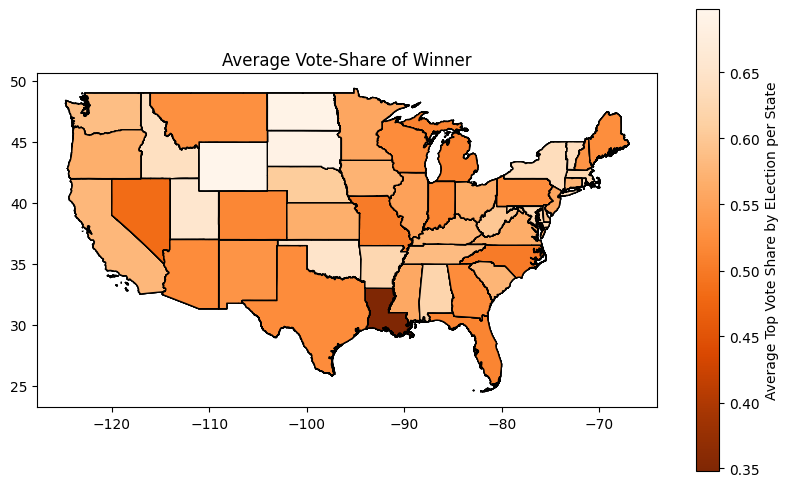

In [139]:
us_states = gpd.read_file('cb_2018_us_state_500k.shp')

continental_us_states = us_states.cx[-125:-65, 25:50]

results_df_new.rename(columns={'state': 'STUSPS'}, inplace=True)

continental_us_states = continental_us_states.merge(results_df_new, on='STUSPS',how='left')

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed


cmap = plt.cm.get_cmap('Oranges_r')

continental_us_states.plot(ax=ax, column='vote_share_max_avg', cmap=cmap, edgecolor='black', legend=True)

cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Average Top Vote Share by ELection per State')


title = 'Average Vote-Share of Winner'
plt.title(f'{title}')


plt.savefig('latest.png')
plot_list.append(plt.gcf())
plot_list_names.append(title)
plt.show()

#### party share by state

In [140]:
# Group by state and party
grouped_df = results_df.groupby(['state', 'party'])

# Filter the groups to retain only those with at least two unique FEC IDs
filtered_df = grouped_df.filter(lambda x: x['fec_id'].nunique() >= 2)

# Group by state and party again to calculate total vote share for each party in each state
party_vote_share = filtered_df.groupby(['state', 'party'], as_index=False)['vote_share'].sum().pivot(index='state', columns='party', values='vote_share').fillna(0)

In [141]:
party_vote_share = party_vote_share[(party_vote_share['D'] != 0) & (party_vote_share['R'] != 0)]
party_vote_share['party_ratio'] = party_vote_share['R'] / party_vote_share['D']
party_vote_share['state'] = party_vote_share.index
# Print column names
print("Column names:")
print(party_vote_share.columns)


Column names:
Index(['D', 'L', 'O', 'R', 'party_ratio', 'state'], dtype='object', name='party')


In [142]:
us_states = gpd.read_file('cb_2018_us_state_500k.shp')

continental_us_states = us_states.cx[-125:-65, 25:50]
party_vote_share.rename(columns={'state': 'STUSPS'}, inplace=True)

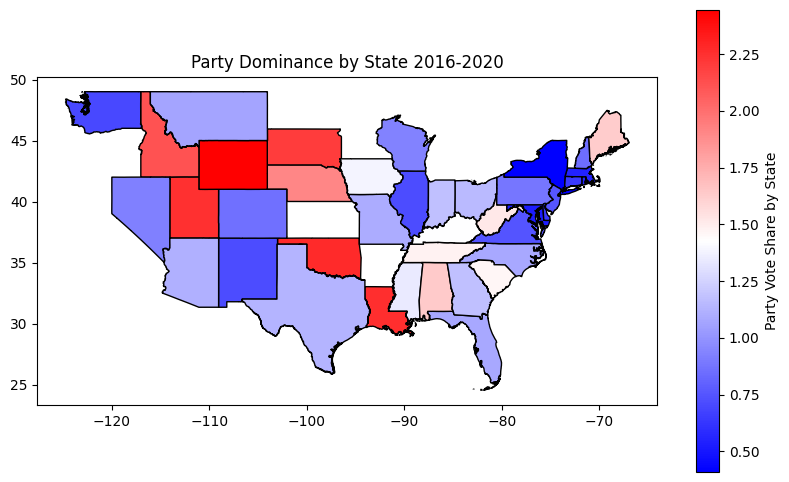

In [143]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap
colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
cmap = LinearSegmentedColormap.from_list('BlueRed', colors)

# Merge the party_vote_share DataFrame with continental_us_states
continental_us_states = continental_us_states.merge(party_vote_share, on='STUSPS', how='left')

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

# Plot the map with the custom colormap
continental_us_states.plot(ax=ax, column='party_ratio', cmap=cmap, edgecolor='black', legend=True)

# Set colorbar label
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Party Vote Share by State')

title = 'Party Dominance by State 2016-2020'
plt.title(f'{title}')


plt.savefig('latest.png')
plot_list.append(plt.gcf())
plot_list_names.append(title)
plt.show()


#### education ratio party scatter plot

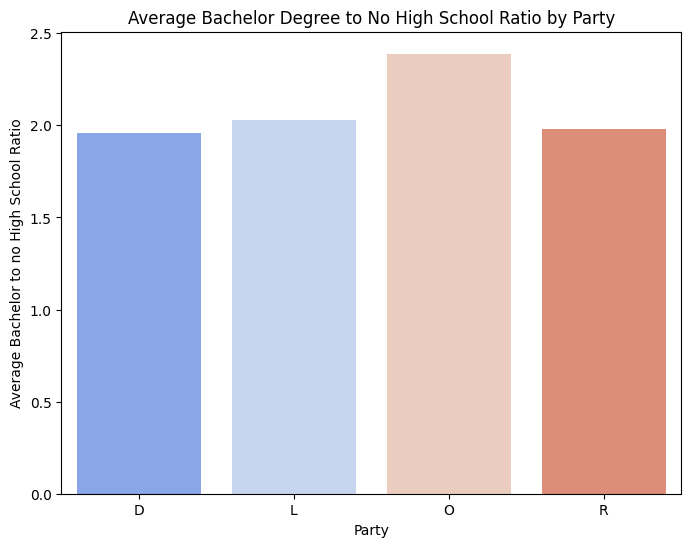

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by party and calculate the mean of bach_high_school_ratio
party_ratio_mean = merged_df5.groupby('party')['bach_high_school_ratio'].mean().reset_index()

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='party', y='bach_high_school_ratio', data=party_ratio_mean, palette='coolwarm')
plt.xlabel('Party')
plt.ylabel('Average Bachelor to no High School Ratio')

title = 'Average Bachelor Degree to No High School Ratio by Party'
plt.title(f'{title}')

plt.savefig('latest.png')
plot_list.append(plt.gcf())
plot_list_names.append(title)
plt.show()


#### education state map country

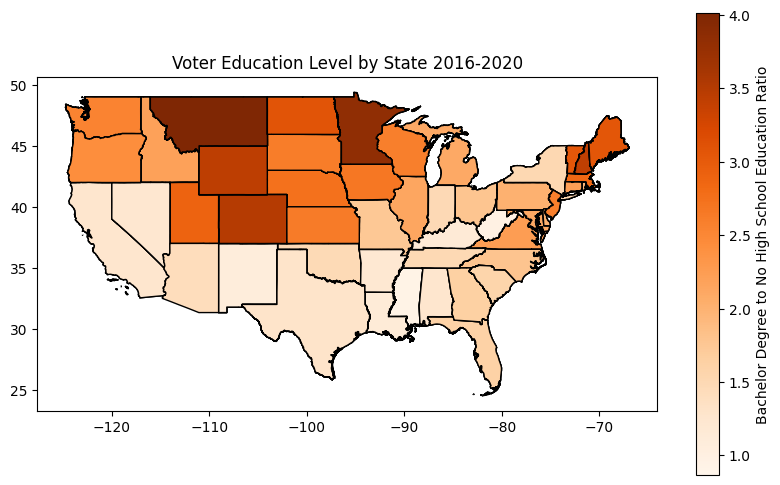

In [145]:
us_states = gpd.read_file('cb_2018_us_state_500k.shp')
continental_us_states = us_states.cx[-125:-65, 25:50]


merged_df5.rename(columns={'state': 'STUSPS'}, inplace=True)
continental_us_states = continental_us_states.merge(merged_df5, on='STUSPS',how='left')

fig, ax = plt.subplots(figsize=(10, 6)) 

cmap = plt.cm.get_cmap('Oranges_r').reversed()

continental_us_states.plot(ax=ax, column='bach_high_school_ratio', cmap=cmap, edgecolor='black', legend=True)

# Set the colorbar label
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Bachelor Degree to No High School Education Ratio')


title = 'Voter Education Level by State 2016-2020'
plt.title(f'{title}')

plt.savefig('latest.png')
plot_list.append(plt.gcf())
plot_list_names.append(title)
plt.show()

In [146]:
for i, plot in enumerate(plot_list):
    name = plot_list_names[i]
    plot.savefig(f'play/{name}.png') 
    print(plot)
    print(i)

Figure(1000x600)
0
Figure(1000x600)
1
Figure(1000x600)
2
Figure(1000x600)
3
Figure(1000x600)
4
Figure(1000x600)
5
Figure(1000x600)
6
Figure(1000x600)
7
Figure(800x600)
8
Figure(1000x600)
9


#### candidates that spent and raised the most accouting for population. top 10's

#### voteshare by avaerga median age of state and party scatter plot

#### per election total_votes # spent